# Building and training machine learning models in Python

In [ ]:
!pip install torch torchviz tensorflow torchmetrics

# Data import and preprocessing
We will use the Palmer Penguins dataset. The task will be to classify three different species of penguins given their body dimensions.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
# Load the Palmer Penguins dataset
url = 'https://raw.githubusercontent.com/allisonhorst/palmerpenguins/master/inst/extdata/penguins.csv'
penguins = pd.read_csv(url)

In [ ]:
penguins.dropna(inplace=True)

In [ ]:
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007


In [ ]:
features = penguins[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']]
labels = pd.get_dummies(penguins['species'])

In [ ]:
scaler = StandardScaler()
features = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [ ]:
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]

In [ ]:
import torch

## Basic tensor operations

Tensors can be declared in many ways

In [ ]:
a = torch.tensor([[1, 2], [3, 4]])
b = torch.tensor([[5, 6], [7, 8]])
c = torch.zeros((2, 2))
d = torch.ones((2, 2))
e = torch.rand((2, 2))

Can be converted directly form numpy arrays

In [ ]:
ds = torch.from_numpy(X_train.values)

In [ ]:
ds.shape

torch.Size([266, 4])

Slicing is supported just like numpy

In [ ]:
ds[1, 1:-2]

tensor([-1.2257,  0.3230], dtype=torch.float64)

Lot of operations and operators are defined in the library (likely all the ones that you need)

In [ ]:
ds.device

device(type='cpu')

In [ ]:
ds.to('cuda')

tensor([[ 0.9353, -1.3553,  0.7884,  0.5198],
        [-1.2257,  0.3230, -0.7122, -1.0660],
        [-0.5664, -0.2873, -0.9980, -1.2525],
        ...,
        [-0.7862,  0.2722, -0.5693, -1.2525],
        [ 0.2211,  0.3230, -0.2120, -0.3197],
        [-1.0792, -0.0838, -1.4268, -1.2836]], device='cuda:0',
       dtype=torch.float64)

In [ ]:
from torch import nn

## Broadcasting

In [ ]:
# Example of broadcasting
a = torch.tensor([[1.], [2.], [3.]]) # Shape (3, 1)
b = torch.tensor([10., 20., 30.])   # Shape (3,) (PyTorch will treat this as (1, 3) for broadcasting with 'a')

print("Tensor a:\n", a)
print("Shape of a:", a.shape)
print("\nTensor b:\n", b)
print("Shape of b:", b.shape)

Tensor a:
 tensor([[1.],
        [2.],
        [3.]])
Shape of a: torch.Size([3, 1])

Tensor b:
 tensor([10., 20., 30.])
Shape of b: torch.Size([3])


When a and b are added, PyTorch broadcasts b to match the shape of a


In [ ]:
c = a + b

print("\nResult of a + b (broadcasting):\n", c)
print("Shape of c:", c.shape)


Result of a + b (broadcasting):
 tensor([[11., 21., 31.],
        [12., 22., 32.],
        [13., 23., 33.]])
Shape of c: torch.Size([3, 3])


### Broadcasting in Loss Computation

When calculating loss, you often have a batch of predictions and a corresponding batch of target labels. Sometimes, target labels might be broadcast to match the prediction shape, especially in cases like per-element loss calculation where a single target applies to multiple outputs.

In [ ]:
predictions = torch.tensor([[0.1, 0.2, 0.7],
                            [0.8, 0.1, 0.1]], requires_grad=True)

Let's say we have a single target value (e.g., a constant or a single true class index) for each sample in the batch. However, the loss function might expect targets with the same shape as predictions for element-wise comparison.
For example, if we are calculating an element-wise loss (like L1 or MSE) and want to compare against a scalar target for each prediction in a row.

In [ ]:
scalar_target = torch.tensor(0.5)
mse_loss = nn.MSELoss()
loss = mse_loss(predictions, scalar_target)

print("Predictions shape:", predictions.shape)
print("Scalar target shape:", scalar_target.shape)
print("Loss (predictions vs scalar_target):", loss)

Predictions shape: torch.Size([2, 3])
Scalar target shape: torch.Size([])
Loss (predictions vs scalar_target): tensor(0.1167, grad_fn=<MseLossBackward0>)


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:634: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([2, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Another common example is CrossEntropyLoss where the target is a class index.
CrossEntropyLoss expects predictions of shape (N, C) and targets of shape (N) or (N, C).
If targets are class indices (N), broadcasting is not explicitly happening on the target tensor itself but the internal mechanism of CrossEntropyLoss effectively performs an operation equivalent to selecting the appropriate prediction for the given class index.

Let's create actual target class indices for our predictions.

In [ ]:
target_indices = torch.tensor([2, 0])

ce_loss = nn.CrossEntropyLoss()
loss_ce = ce_loss(predictions, target_indices)

print("\nPredictions shape for CrossEntropyLoss:", predictions.shape)
print("Target indices shape for CrossEntropyLoss:", target_indices.shape)
print("Cross Entropy Loss:")
print(loss_ce)


Predictions shape for CrossEntropyLoss: torch.Size([2, 3])
Target indices shape for CrossEntropyLoss: torch.Size([2])
Cross Entropy Loss:
tensor(0.7288, grad_fn=<NllLossBackward0>)


The key takeaway is how PyTorch automatically handles operations between tensors of different shapes, as long as they are compatible according to broadcasting rules. This simplifies writing flexible loss functions.

# Tensorflow & Keras

### Sequential APIs

In [ ]:
# Install TensorFlow (uncomment the line below if not already installed)
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

# Define a simple model
model = Sequential([
    # Dense layers are fully connected layers
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(output_dim, activation='softmax')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
from keras.callbacks import EarlyStopping, LearningRateScheduler

In [ ]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[EarlyStopping(monitor="val_loss", patience=10)])

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 228ms/step - accuracy: 0.3678 - loss: 0.6536 - val_accuracy: 0.8519 - val_loss: 0.5953
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8443 - loss: 0.5779 - val_accuracy: 1.0000 - val_loss: 0.5267
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9370 - loss: 0.5183 - val_accuracy: 1.0000 - val_loss: 0.4645
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9527 - loss: 0.4454 - val_accuracy: 1.0000 - val_loss: 0.4084
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9613 - loss: 0.4039 - val_accuracy: 1.0000 - val_loss: 0.3583
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9727 - loss: 0.3652 - val_accuracy: 1.0000 - val_loss: 0.3135
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9781 - loss: 0.3205 - val_accuracy: 1.0000 - val_loss: 0.2738
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9618 - loss: 0.2799 - val_accuracy: 1.0000 - val_loss

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print('Test accuracy:', accuracy)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 1.0000 - loss: 0.0114
Test accuracy: 1.0


### Functional APIs

In [ ]:
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense


# Define a simple model with Functional API
input_layer = Input(shape=(input_dim,))
x = Dense(64, activation='relu')(input_layer)
x1 = Dense(32, activation='relu')(x)
x2 = Dense(32, activation='relu')(x)
output_layer = Dense(output_dim, activation='softmax')(x1+x2)

model = Model(inputs=input_layer, outputs=output_layer)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'recall'])
print(model.summary())
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, callbacks=[EarlyStopping(monitor="val_loss", patience=10)])
# Evaluate the model
loss, accuracy, recall = model.evaluate(X_test, y_test)
print('Test accuracy:', accuracy)

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_33 (Dense)    │ (None, 64)        │        320 │ input_layer_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_34 (Dense)    │ (None, 32)        │      2,080 │ dense_33[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_35 (Dense)    │ (None, 32)        │      2,080 │ dense_33[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 32)        │          0 │ dense_34[0][0],   │
│                     │                   │            │ dense_35[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_36 (Dense)    │ (None, 3)         │         99 │ add_6[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,579 (17.89 KB)

 Trainable params: 4,579 (17.89 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 276ms/step - accuracy: 0.3809 - loss: 0.7533 - recall: 0.0101 - val_accuracy: 0.8519 - val_loss: 0.6392 - val_recall: 0.2222
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8500 - loss: 0.6114 - recall: 0.3626 - val_accuracy: 0.9074 - val_loss: 0.5154 - val_recall: 0.7963
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8622 - loss: 0.5027 - recall: 0.7365 - val_accuracy: 0.9074 - val_loss: 0.4193 - val_recall: 0.8333
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9116 - loss: 0.4053 - recall: 0.8093 - val_accuracy: 0.8889 - val_loss: 0.3446 - val_recall: 0.8333
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9260 - loss: 0.3329 - recall: 0.8334 - val_accuracy: 0.8889 - val_loss: 0.2843 - val_recall: 0.8519
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9145 - loss: 0.2762 - recall: 0.8536 - val_accuracy: 0.9074 - val_loss: 0.2366 - val_recall: 0.9074
Epoch 7/20
7/7 ━

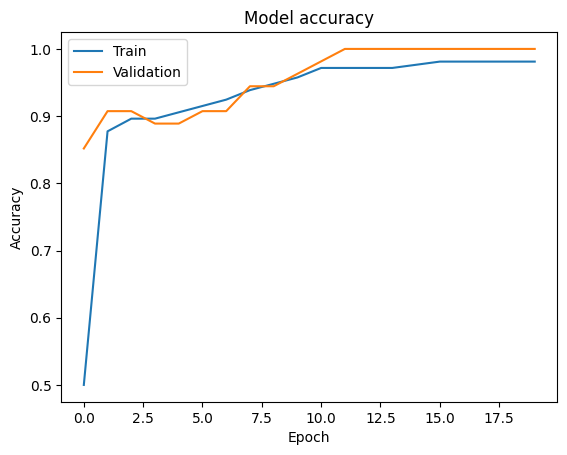

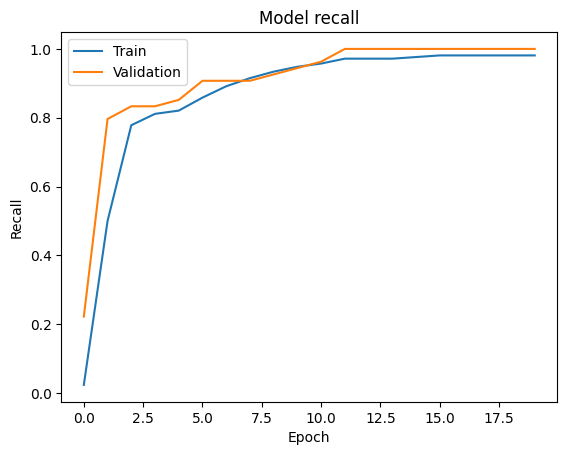

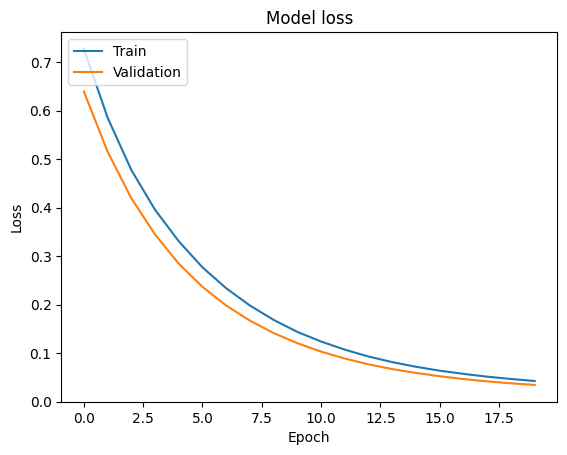

In [ ]:
# prompt: plot learning curves
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Model recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# PyTorch

In [ ]:
!pip install torch # check your device GPU drivers and install the right version following https://pytorch.org/get-started/locally/

## Autograd & Computational Graph
PyTorch's automatic differentiation engine that powers neural network training. It allows you to compute gradients automatically, which is essential for optimizing model parameters using gradient-based methods like stochastic gradient descent (SGD).

In [ ]:
# When you create a tensor with `requires_grad=True`, PyTorch starts tracking all operations performed on it. This is necessary for computing gradients later.
x = torch.randn(3, requires_grad=True)

# Perform some operations
y = x * 2
z = y.mean()+y.max()

# The `backward()` method computes the gradient of the output (`z` in this case) with respect to all tensors that have `requires_grad=True`.

z.backward()

# The `grad` attribute of a tensor stores the computed gradient. In this example, `x.grad` will contain the gradient of `z` with respect to `x`.
print(z.shape, x.grad)


torch.Size([]) tensor([2.6667, 0.6667, 0.6667])


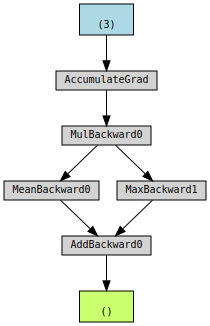

In [ ]:
from torchviz import make_dot
make_dot(z)

## Sequential APIs

In [ ]:
# Install PyTorch (uncomment the line below if not already installed)

import torch.nn as nn

# Define a simple model
model = nn.Sequential(
    nn.Linear(10, 64),
    nn.ReLU(),
    nn.Linear(64, 1),
    nn.Sigmoid()
)

print(model)

Sequential(
  (0): Linear(in_features=10, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=1, bias=True)
  (3): Sigmoid()
)


In [ ]:
from torchmetrics import Accuracy, F1Score
from torchmetrics.functional import accuracy, f1_score

In [ ]:
my_f1score = F1Score(task='binary', average='macro')

my_f1score(tensor_a, tensor_b)

f1_score(tensora , tensorb, task, ave)

## Building complex architectures: nn.Module

In [ ]:
# prompt: create a neural network for the penguins task extending nn.Module

class PenguinClassifier(nn.Module):
  def __init__(self, config):
    super(PenguinClassifier, self).__init__()
    self.layers = nn.ModuleList()

    self.layers.append(nn.Linear(config['input_dim'], config['hidden_dim']))

    for i in range(config['hidden_layers']):
      self.layers.append(nn.Linear(config['hidden_dim'], config['hidden_dim']))

    self.layers.append(nn.Linear(config['hidden_dim'], config['output_dim']))
    self.relu = nn.ReLU()
    self.softmax = nn.Softmax(dim=1)

  def forward(self, x):
    for layer in self.layers[:-1]:
      x = self.relu(layer(x))
    x = self.softmax(self.layers[-1](x))
    return x


config = {
    "input_dim": input_dim,
    "hidden_dim": 64,
    "hidden_layers": 1,
    "output_dim": output_dim
}



## Dataloaders and Datasets
Are useful to handle batches loading

In [ ]:
from torch.utils.data import Dataset, DataLoader

class PenguinDataLoader(DataLoader):
  def __init__(self, dataset, batch_size, shuffle=True):
    super(PenguinDataLoader, self).__init__(dataset, batch_size=batch_size, shuffle=shuffle)

class PenguinDataset(Dataset):
  def __init__(self, X, y):
    self.X = torch.tensor(X.values, dtype=torch.float32)
    self.y = torch.tensor(y.values, dtype=torch.float32)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

## Training Neural Networks

Autograd is crucial for training neural networks in PyTorch. Here's
how it works in a typical training loop:

1. **Forward Pass:** The input data is fed through the network,
and the output is computed.

2. **Compute Loss:** The loss function is calculated based on
the network's output and the target labels.

3. **Backward Pass:** `loss.backward()` is called to compute the gradient of the loss with respect to all model parameters (weights and biases) that have `requires_grad=True`.
4. **Update Parameters:** An optimizer (like SGD) is used to update the model parameters based on the computed gradients.

In [ ]:
from torchmetrics.functional import accuracy, specificity, auroc, recall, precision, f1_score, matthews_corrcoef

In [ ]:
import torch.optim as optim

In [ ]:
import numpy as np

In [ ]:
# Instantiate the model
torch.random.manual_seed(42)

model = PenguinClassifier(config)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.1, betas=(0.867, 0.9666))

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5)



# Create datasets and data loaders
train_dataset = PenguinDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = PenguinDataset(X_test, y_test)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

best_loss = float('inf')
counter = 0
# Training loop
num_epochs = 20
for epoch in range(num_epochs):
  for batch_idx, (data, target) in enumerate(train_loader):
    # Zero the gradients
    # optimizer.zero_grad()

    # Forward pass
    output = model(data)
    # Calculate loss
    loss = criterion(output, target)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    scheduler.step(loss)
    acc = accuracy(output, target, task='multiclass', num_classes=3)

    losses = []
    with torch.no_grad():
      for val_batch, (vdata, vtarget) in enumerate(val_loader):
        voutput = model(vdata)
        vloss = criterion(voutput, vtarget)
        losses.append(vloss.item())
      vloss = np.mean(losses)

      if vloss < best_loss:
        best_loss = vloss
        torch.save(model.state_dict(), 'best_penguin_classifier.pth')
        counter = 0
      else:
        counter +=1
      if counter >= 10:
        print(f"Loss di not improve for {counter} epochs. Stopping...")
        break


    # Print progress
    print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}, Accuracy: {acc:.4f}')


Epoch [1/20], Step [1/5], Loss: 1.0937, Accuracy: 0.0000
Epoch [1/20], Step [2/5], Loss: 0.7925, Accuracy: 0.0000
Epoch [1/20], Step [3/5], Loss: 0.7010, Accuracy: 0.0417
Epoch [1/20], Step [4/5], Loss: 0.6152, Accuracy: 0.1510
Epoch [1/20], Step [5/5], Loss: 0.6735, Accuracy: 0.1333
Epoch [2/20], Step [1/5], Loss: 0.5675, Accuracy: 0.2708
Epoch [2/20], Step [2/5], Loss: 0.6624, Accuracy: 0.3021
Epoch [2/20], Step [3/5], Loss: 0.7374, Accuracy: 0.6198
Epoch [2/20], Step [4/5], Loss: 0.7564, Accuracy: 0.6875
Epoch [2/20], Step [5/5], Loss: 0.8514, Accuracy: 0.7667
Epoch [3/20], Step [1/5], Loss: 0.6765, Accuracy: 0.8594
Epoch [3/20], Step [2/5], Loss: 0.6139, Accuracy: 0.9062
Epoch [3/20], Step [3/5], Loss: 0.5983, Accuracy: 0.9271
Epoch [3/20], Step [4/5], Loss: 0.5983, Accuracy: 0.9427
Loss di not improve for 10 epochs. Stopping...
Loss di not improve for 11 epochs. Stopping...
Loss di not improve for 12 epochs. Stopping...
Loss di not improve for 13 epochs. Stopping...
Loss di not im

In [ ]:
best_model = model.load_state_dict(torch.load('best_penguin_classifier.pth'))

In [ ]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',patience=5)
best_loss =

for epoch in range(num_epochs):
  for batch_idx, (data, target) in enumerate(train_loader):
    # Zero the gradients
    # optimizer.zero_grad()

    # Forward pass
    output = model(data)
    # Calculate loss
    loss = criterion(output, target)


    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    acc = accuracy(output, target, task='multiclass', num_classes=3)
    scheduler.step()

    vlosses = []
    vaccs = []
    for vbatch_ifx, (vdata, vtarget) in enumerate(val_loader):
      voutput = model(vdata)
      vloss = criterion(voutput, vtarget)
      vacc = accuracy(voutput, vtarget, task='multiclass', num_classes=3)
      vlosses.append(vloss.item())
      vaccs.append(vacc.item())
    vloss = np.mean(vlosses)
    vacc = np.mean(vaccs)

    if vloss<best_loss:
      best_loss=vloss
      counter=0
      torch.save(model.state_dict(), 'best_penguin_classifier.pth')
    else:
      counter += 1
    if counter >= patience:
      print(f"Loss di not improve for {counter} epochs. Stopping...")

    # Print progress
    print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}, Accuracy: {acc:.4f}')


SyntaxError: invalid syntax (ipython-input-920911388.py, line 2)

In [ ]:
make_dot(loss, params=dict(model.named_parameters()))